In [1]:
import torch
import torchvision
from torchvision import datasets,transforms, models
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable 
import time
%matplotlib inline

In [2]:
path = "dog_vs_cat"
transform = transforms.Compose([transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])

In [29]:
data_image = {x:datasets.ImageFolder(root = os.path.join(path,x),
                                     transform = transform)
              for x in ["train", "val"]}

data_loader_image = {x:torch.utils.data.DataLoader(dataset=data_image[x],
                                                batch_size = 4,
                                                shuffle = True)
                     for x in ["train", "val"]}

In [30]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

True


In [31]:
classes = data_image["train"].classes
classes_index = data_image["train"].class_to_idx
print(classes)
print(classes_index)

['cat', 'dog']
{'cat': 0, 'dog': 1}


In [32]:
print("train data set:", len(data_image["train"]))
print("val data set:", len(data_image["val"]))

train data set: 100
val data set: 100


['dog', 'dog', 'cat', 'cat']


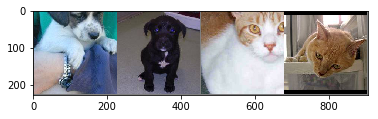

In [33]:
X_train,y_train = next(iter(data_loader_image["train"]))
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
img = torchvision.utils.make_grid(X_train)
img = img.numpy().transpose((1,2,0))
img = img*std + mean

print([classes[i] for i in y_train])
plt.imshow(img)

In [63]:
model = models.vgg16(pretrained = True)
# print(model)

In [34]:
for parma in model.parameters():
    parma.requires_grad = False

model.classifier = torch.nn.Sequential(torch.nn.Linear(25088, 4096),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(p=0.5),
                                       torch.nn.Linear(4096, 4096),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(p=0.5),
                                       torch.nn.Linear(4096, 2))

for index, parma in enumerate(model.classifier.parameters()):
    if index == 6:
        parma.requires_grad = True
    
if use_gpu:
    model = model.cuda()


cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters())

In [62]:
# print(model)

In [61]:
n_epochs = 1
for epoch in range(n_epochs):
    since = time.time()
    print("Epoch{}/{}".format(epoch, n_epochs))
    print("-"*10)
    for param in ["train", "val"]:
        if param == "train":
            model.train = True
        else:
            model.train = False
            
        running_loss = 0.0
        running_correct = 0
        batch = 0
        for data in data_loader_image[param]:
            batch += 1
            X,y = data
            
            if use_gpu:
                X,y = Variable(X.cuda()), Variable(y.cuda())
            else:
                X,y = Variable(X), Variable(y)
            
            optimizer.zero_grad()
            y_pred = model(X)
            _,pred = torch.max(y_pred.data, 1)
            
            loss = cost(y_pred,y)
            if param == "train":
                loss.backward()
                optimizer.step()
            running_loss += loss.item()
            running_correct += torch.sum(pred == y.data)
            if batch%5 == 0 and param == "train":
                print("Batch {}, Train Loss:{:.4f}, Train ACC:{:.4f}".format(
                batch, running_loss/(4*batch), 100*running_correct/(4*batch)))
                
        epoch_loss = running_loss/len(data_image[param])
        epoch_correct = 100*running_correct/len(data_image[param])
        
        print("{} Loss:{:.4f}, Correct:{:.4f}".format(param, epoch_loss, epoch_correct))
    now_time = time.time() - since
    print("Training time is:{:.0f}m {:.0f}s".format(now_time//60, now_time%60))

Epoch0/1
----------
Batch 5, Train Loss:0.0000, Train ACC:100.0000
Batch 10, Train Loss:0.0000, Train ACC:100.0000
Batch 15, Train Loss:0.0000, Train ACC:100.0000
Batch 20, Train Loss:0.0000, Train ACC:100.0000
Batch 25, Train Loss:0.0000, Train ACC:100.0000
train Loss:0.0000, Correct:100.0000
val Loss:0.0036, Correct:99.0000


In [57]:
data_test_img = datasets.ImageFolder(root="dog_vs_cat/val/", transform = transform)
data_loader_test_img = torch.utils.data.DataLoader(dataset=data_test_img,
                                                  batch_size = 16)

In [1]:
image, label = next(iter(data_loader_test_img))
images = Variable(image).cuda()
y_pred = model(images)
_,pred = torch.max(y_pred.data, 1)
print(pred)

NameError: name 'data_loader_test_img' is not defined

Pred Label: ['cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat']


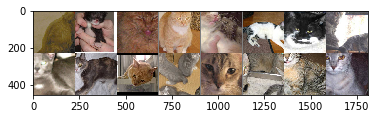

In [59]:
img = torchvision.utils.make_grid(image)
img = img.numpy().transpose(1,2,0)
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
img = img * std + mean
print("Pred Label:", [classes[i] for i in pred])
plt.imshow(img)